In [1]:
from IPython import display

from os import name

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import numpy.polynomial.polynomial as poly
# import PIL
import tensorflow as tf
# import tensorflow_probability as tfp
# import tensorflow.contrib as tf_contrib
import time
import datetime

import seaborn as sns
from data_utils import *

# from keras.datasets.cifar10 import load_data

import scipy as sp
from numpy.random import default_rng

#imp

import keras.backend as K

tf.keras.backend.set_image_data_format('channels_last')

2022-10-28 11:35:56.208984: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Define Model

In [40]:
def define_discriminator(in_shape=(16,16,1), n_classes=8):
    in_label = tf.keras.layers.Input(shape=(1, n_classes), name='d_label')
    li = tf.keras.layers.Embedding(n_classes, 50, name='d_embed')(in_label) # Shape 7,50
    # print(li.shape)
    n_nodes = in_shape[0] * in_shape[1] # 16x16 = 256
    li = tf.keras.layers.Dense(n_nodes, name='d_dense1')(li) # Shape 1,256
    # print(li.shape)
    li = tf.keras.layers.Reshape((in_shape[0], in_shape[1], n_classes), name='d_reshape1')(li) # 16x16x1

    in_image = tf.keras.layers.Input(shape=in_shape, name='d_in_image') # 16x16x1
    merge = tf.keras.layers.Concatenate(name='d_concat')([in_image, li]) # 16x16x2
    fe = tf.keras.layers.Conv2D(128, (3,3), strides=(2,2), padding='same', name='d_conv1')(merge) # 8x8x128
    fe = tf.keras.layers.LeakyReLU(alpha=0.2)(fe) 
    fe = tf.keras.layers.Conv2D(128, (3,3), strides=(2,2), padding='same', name='d_conv2')(fe) # 4x4x128
    fe = tf.keras.layers.LeakyReLU(alpha=0.2)(fe)
    fe = tf.keras.layers.Flatten(name='d_flatten')(fe) # (4x4x128) = 2048
    fe = tf.keras.layers.Dropout(0.4, name='d_droput')(fe)
    out_layer = tf.keras.layers.Dense(1, activation='sigmoid', name='d_dense2')(fe) # Shape = 1

    model = tf.keras.Model([in_image, in_label], out_layer)
    opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', 'mae'])
    return model

In [41]:
test_discr = define_discriminator()
print(test_discr.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 d_label (InputLayer)           [(None, 1, 8)]       0           []                               
                                                                                                  
 d_embed (Embedding)            (None, 1, 8, 50)     400         ['d_label[0][0]']                
                                                                                                  
 d_dense1 (Dense)               (None, 1, 8, 256)    13056       ['d_embed[0][0]']                
                                                                                                  
 d_in_image (InputLayer)        [(None, 16, 16, 1)]  0           []                               
                                                                                              

/Users/probook/opt/miniconda3/envs/mobility/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [42]:
def define_generator(latent_dim, n_classes=8):
    in_label = tf.keras.layers.Input(shape=(1, n_classes), name='g_label')
    # print(in_label.shape)
    li = tf.keras.layers.Embedding(n_classes, 50, name='g_embed')(in_label) # Shape 5,50
    # print layer shape
    # print(li.shape)
    n_nodes = 4 * 4 # To match dim for concatenation later
    li = tf.keras.layers.Dense(n_nodes, name='g_dense1')(li) # Shape 5,25
    # print(li.shape)
    li = tf.keras.layers.Reshape((4, 4, n_classes), name='g_reshape1')(li) # 4x4x1

    in_lat = tf.keras.layers.Input(shape=(latent_dim,), name='g_in_latent') # Input dim of 100

    n_nodes = 128 * 4 * 4 # 2048
    gen = tf.keras.layers.Dense(n_nodes, name='g_dense2')(in_lat) # Shape 2048
    gen = tf.keras.layers.LeakyReLU(alpha=0.2)(gen)
    gen = tf.keras.layers.Reshape((4, 4, 128), name='g_reshape2')(gen) # 4x4x128
    # print(gen.shape)

    merge = tf.keras.layers.Concatenate(name='g_concat')([gen, li]) # 4x4x129 (Extra channel for label)
    gen = tf.keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', name='g_convT1')(merge) # 8x8x128
    gen = tf.keras.layers.LeakyReLU(alpha=0.2)(gen)
    gen = tf.keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', name='g_convT2')(gen) # 16x16x128
    gen = tf.keras.layers.LeakyReLU(alpha=0.2)(gen)
    
    out_layer = tf.keras.layers.Conv2D(1, (8,8), activation='tanh', padding='same', name='g_conv')(gen) # 16x16x3

    model = tf.keras.Model([in_lat, in_label], out_layer)
    return model

In [43]:
test_gen = define_generator(100, n_classes=8)
print(test_gen.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 g_in_latent (InputLayer)       [(None, 100)]        0           []                               
                                                                                                  
 g_label (InputLayer)           [(None, 1, 8)]       0           []                               
                                                                                                  
 g_dense2 (Dense)               (None, 2048)         206848      ['g_in_latent[0][0]']            
                                                                                                  
 g_embed (Embedding)            (None, 1, 8, 50)     400         ['g_label[0][0]']                
                                                                                            

In [44]:
# Create a custom loss function for the mean absolute error of the generated images
def mae_loss(y_true, y_pred):
    return K.mean(K.abs(y_pred - y_true), axis=-1)


In [45]:
def define_gan(generator, discriminator):
    discriminator.trainable = False

    gen_noise, gen_label = generator.input
    gen_output = generator.output
    gan_output = discriminator([gen_output, gen_label])
    model = tf.keras.Model([gen_noise, gen_label], gan_output)
    opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', 'mae'])
    return model

In [46]:
test_gan = define_gan(test_gen, test_discr)
print(test_gan.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 g_in_latent (InputLayer)       [(None, 100)]        0           []                               
                                                                                                  
 g_label (InputLayer)           [(None, 1, 8)]       0           []                               
                                                                                                  
 g_dense2 (Dense)               (None, 2048)         206848      ['g_in_latent[0][0]']            
                                                                                                  
 g_embed (Embedding)            (None, 1, 8, 50)     400         ['g_label[0][0]']                
                                                                                            

# Data Loading + Helper Functions

In [47]:
data_dir = '/Users/probook/Documents/GitHub/mobility-mini-project/data/'
# Read in data from csv to numpy array
taxi = np.load((data_dir + 'gan_taxi_2021.npy'))
bike = np.load((data_dir + 'gan_bike_2021.npy'))
weather = np.load((data_dir + 'gan_weather_2021.npy'))

In [48]:
print(taxi.shape, bike.shape, weather.shape)

(8760, 16, 16, 1) (8760, 16, 16, 1) (8760, 1, 8)


In [49]:
def load_mobility_data(data_type = 'Taxi'):
    # Load mobility data
    if data_type == 'Taxi':
        data = taxi
    elif data_type == 'Bike':
        data = bike
    trainX = data
    trainY = weather
    # print('load_mobility_data', trainX.shape, trainY.shape)
    # trainX = bike
    # trainY = np.expand_dims(weather, axis=-1)
    return [trainX, trainY]

In [50]:
def load_real_samples(data_type='Taxi'):
    # (trainX, trainy), (_, _) = load_data()
    # print(trainX.shape, trainy.shape)
    (trainX, trainy) = load_mobility_data(data_type)
    # X = np.expand_dims(trainX, axis=-1)
    X = trainX.astype('float32')
    y = trainy
    # print('load_real_samples', X.shape, y.shape)
    return [X, y]

In [51]:
def generate_real_samples(dataset, n_samples):
    images, labels = dataset
    ix = np.random.randint(0, images.shape[0], n_samples)
    X, labels = images[ix], labels[ix]
    y = np.ones((n_samples, 1))
    # print('generate_real_samples', X.shape, labels.shape, y.shape)
    return [X, labels], y

In [52]:
def generate_latent_points(latent_dim, n_samples, n_classes=8):
    x_input = np.random.randn(latent_dim * n_samples)
    z_input = x_input.reshape(n_samples, latent_dim)
    # Generate labels array of shape (n_samples, 1, n_classes) with random integers from 0 to 12 for column 1, 0 to 6 for column 2, 0 to 23 for column 3, and 0 to 1 for columns 4 through 8
    ranges = np.array([[0,12], [0,7], [0,24], [0,2], [0,2], [0,2], [0,2], [0,2]])
    labels = np.random.randint(low=ranges[:,0], high=ranges[:,1], size=(n_samples, 1, ranges.shape[0]))
    # print('generate_latent_points', z_input.shape, labels.shape)
    return [z_input, labels]

In [53]:
def generate_fake_samples(generator, latent_dim, n_samples):
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    images = generator.predict([z_input, labels_input])
    y = np.zeros((n_samples, 1))
    # print('generate_fake_samples', images.shape, labels_input.shape, y.shape)
    return [images, labels_input], y

In [54]:
def show_fakes(generator, latent_dim, n=10):
    
    # Get fake (generated) samples
    x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
    
    # Rescale from [-1, 1] to [0, 1]
    X_tst = (x_fake[0] + 1) / 2.0
    
    # Display fake (generated) images
    fig, axs = plt.subplots(2, 5, sharey=False, tight_layout=True, figsize=(12,6), facecolor='white')
    k=0
    for i in range(0,2):
        for j in range(0,5):
            axs[i,j].imshow(X_tst[k], cmap='YlGnBu')
            axs[i,j].set(title=x_fake[1][k])
            axs[i,j].axis('off')
            k=k+1
    plt.show() 

# Train

In [57]:
def train(generator, discriminator, gan, mode, dataset, latent_dim, n_epochs=5, n_batch=8, n_eval=200):
    gan_metrics = np.empty((n_epochs, 5))
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    print(' bat_per_epo: ', bat_per_epo)
    half_batch = int(n_batch / 2)
    for i in range(n_epochs):
        for j in range(bat_per_epo):

            [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
            # print('generate_real_samples', X_real.shape, labels_real.shape, y_real.shape)
            d_loss1, d_acc1, d_mae1 = discriminator.train_on_batch([X_real, labels_real], y_real)
            [X_fake, labels], y_fake = generate_fake_samples(generator, latent_dim, half_batch)
            d_loss2, d_acc2, d_mae2 = discriminator.train_on_batch([X_fake, labels], y_fake)
            d_loss, d_acc, d_mae = 0.5 * np.add(d_loss1, d_loss2), 0.5 * np.add(d_acc1, d_acc2), 0.5 * np.add(d_mae1, d_mae2)
            # Train generator 10 times for every 1 time discriminator is trained
            for k in range(10):
                [z_input, z_labels] = generate_latent_points(latent_dim, n_batch)
                y_gan = np.ones((n_batch, 1))

                g_loss, g_acc, g_mae = gan.train_on_batch([z_input, z_labels], y_gan)
                k+=1
                
            if (j) % n_eval ==0:
                print('Epoch: %d/%d, Batch: %d/%d, d loss=%.3f, d acc=%.3f, d mae=%.3f, g loss=%.3f, g mae%.3f' % (i+1, n_epochs, j+1, bat_per_epo, d_loss, d_acc, d_mae, g_loss, g_mae))
                show_fakes(generator, latent_dim)
        # summarize loss on this epoch
        # Save metrics to gan_metrics array
        gan_metrics[i, 0] = d_loss
        gan_metrics[i, 1] = d_acc
        gan_metrics[i, 2] = d_mae
        gan_metrics[i, 3] = g_loss
        gan_metrics[i, 4] = g_mae
    # generator.save('cgan_gen.h5')
        # Save the gan model after each epoch with the epoch number in the name
        gan.save(str(mode) + '_cgan_gan_' + str(i) + '.h5')
        generator.save(str(mode) + '_cgan_gen_' + str(i) + '.h5')

    # gan.save('cgan_gan.h5')
    return gan_metrics

 bat_per_epo:  1095


2022-10-28 11:58:24.210809: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-28 11:58:26.008853: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 599ms/step


2022-10-28 11:58:27.199278: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-28 11:58:31.018443: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch: 1/10, Batch: 1/1095, d loss=0.696, d acc=0.125, d mae=0.501, g loss=0.658, g mae0.482
1/1 [==============================] - 0s 199ms/step


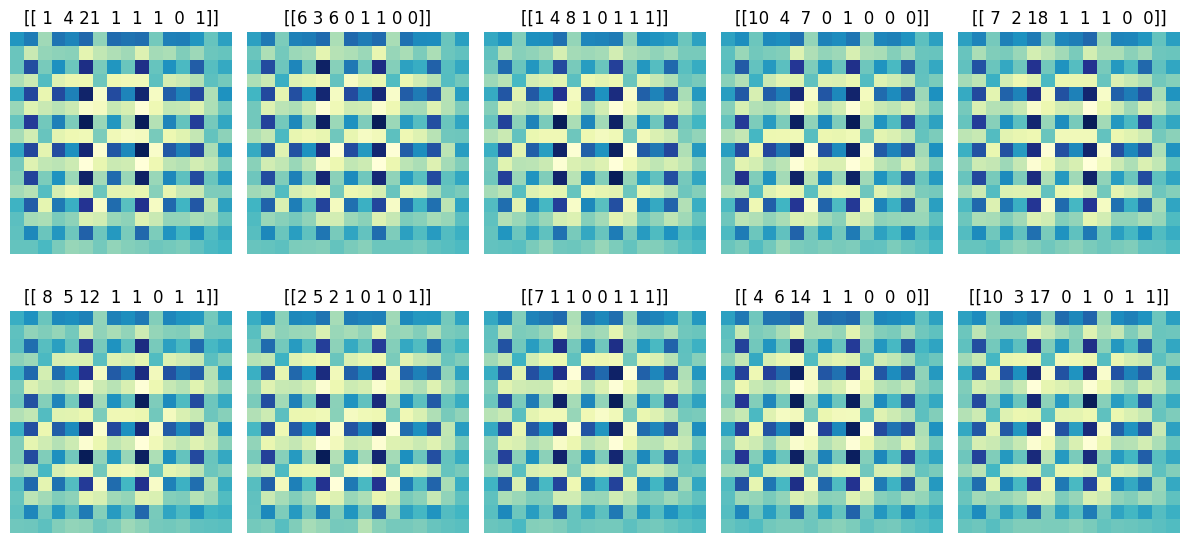

1/1 [==============================] - 0s 112ms/step
Epoch: 1/10, Batch: 201/1095, d loss=0.009, d acc=1.000, d mae=0.009, g loss=8.679, g mae0.993
1/1 [==============================] - 0s 141ms/step


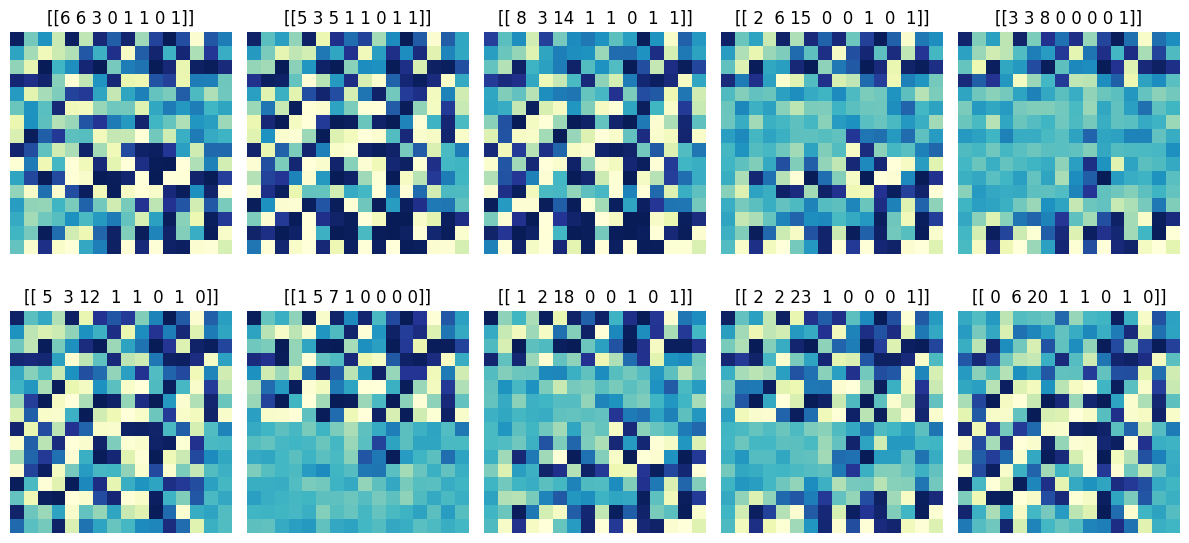

1/1 [==============================] - 0s 196ms/step
Epoch: 1/10, Batch: 401/1095, d loss=0.002, d acc=1.000, d mae=0.002, g loss=12.537, g mae1.000
1/1 [==============================] - 0s 258ms/step


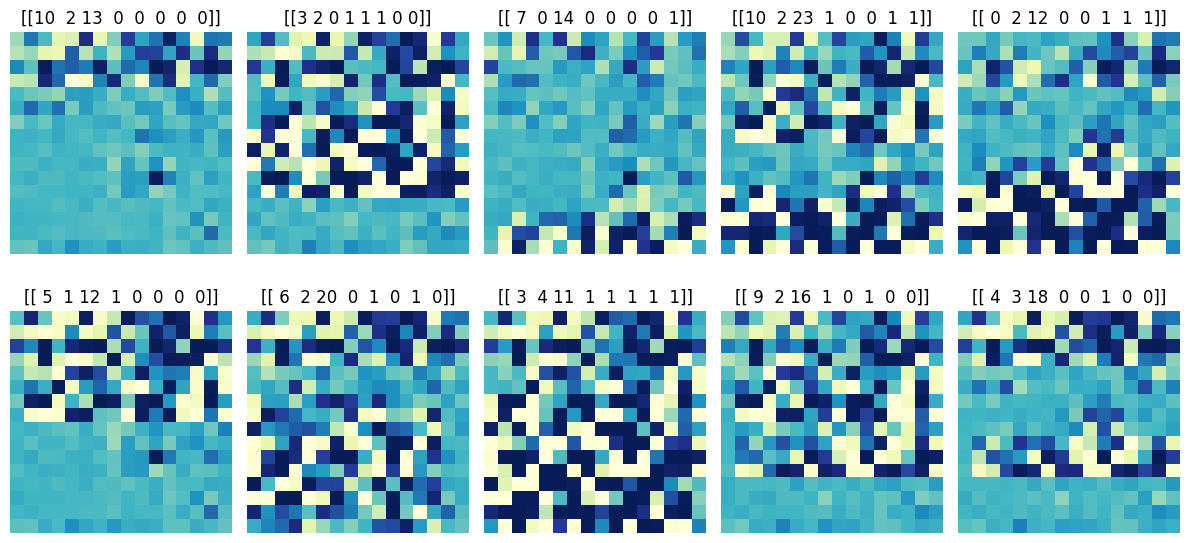

1/1 [==============================] - 0s 47ms/step
Epoch: 1/10, Batch: 601/1095, d loss=0.001, d acc=1.000, d mae=0.001, g loss=16.061, g mae1.000
1/1 [==============================] - 0s 47ms/step


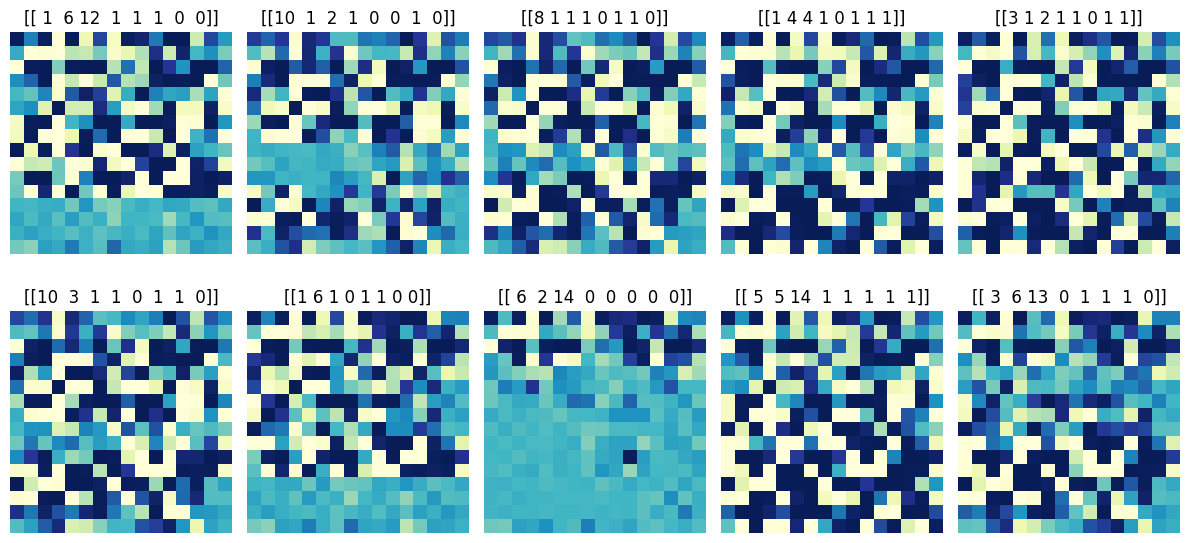

1/1 [==============================] - 0s 46ms/step
Epoch: 1/10, Batch: 801/1095, d loss=0.001, d acc=1.000, d mae=0.001, g loss=15.738, g mae1.000
1/1 [==============================] - 0s 49ms/step


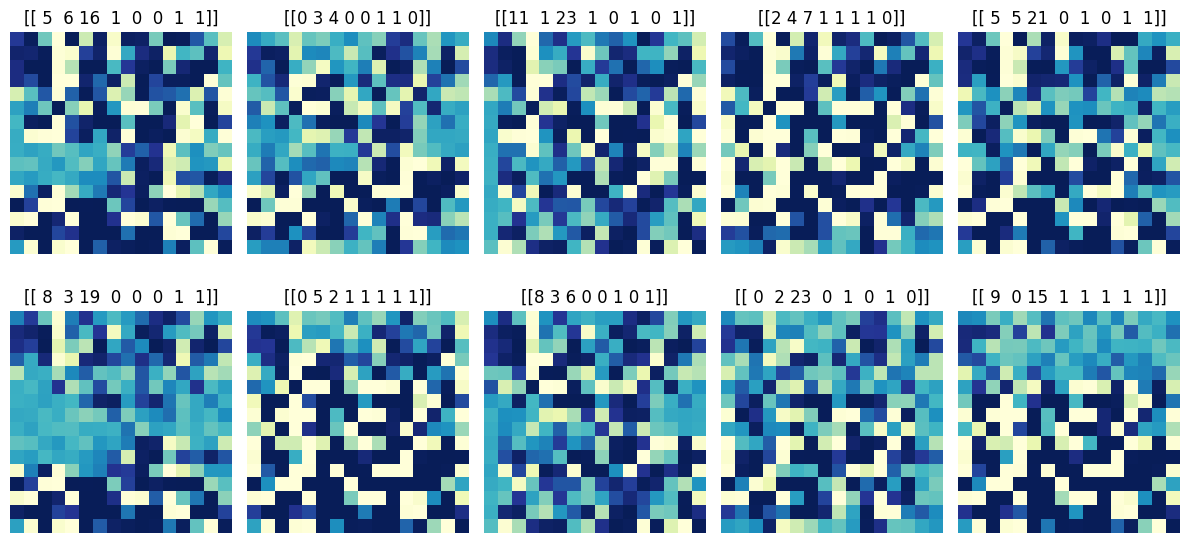

1/1 [==============================] - 0s 33ms/step
Epoch: 1/10, Batch: 1001/1095, d loss=0.000, d acc=1.000, d mae=0.000, g loss=13.137, g mae1.000
1/1 [==============================] - 0s 48ms/step


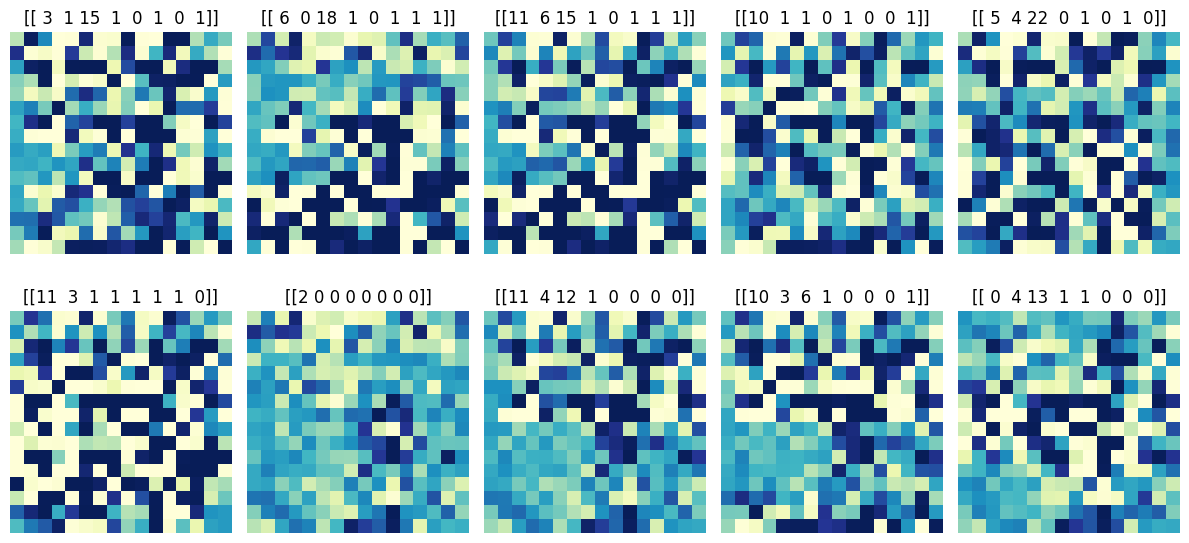

1/1 [==============================] - 0s 50ms/step
Epoch: 2/10, Batch: 1/1095, d loss=0.001, d acc=1.000, d mae=0.001, g loss=14.679, g mae1.000
1/1 [==============================] - 0s 62ms/step


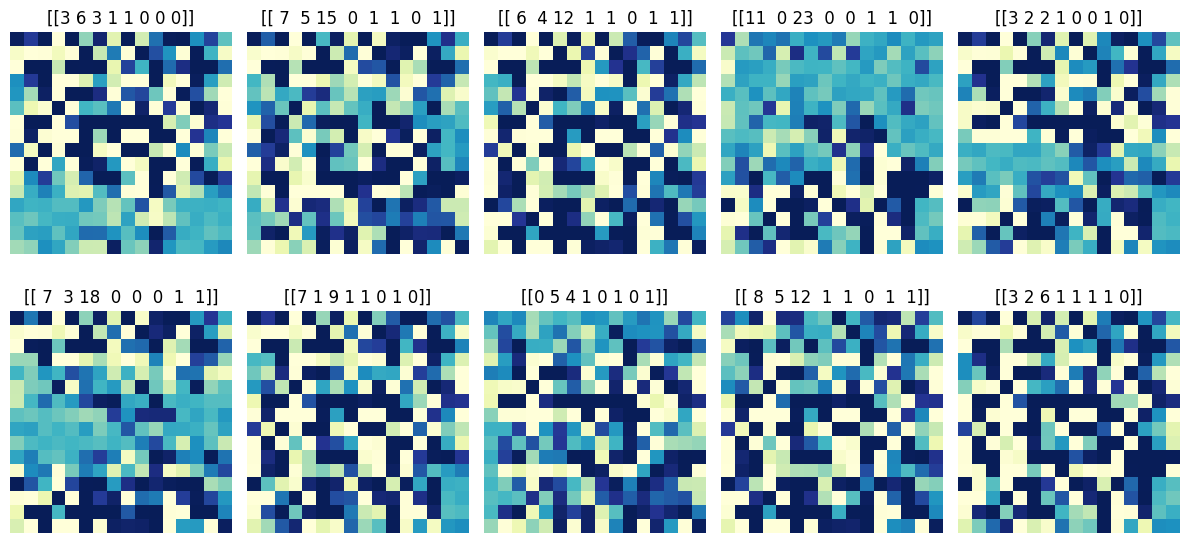

1/1 [==============================] - 0s 35ms/step
Epoch: 2/10, Batch: 201/1095, d loss=0.002, d acc=1.000, d mae=0.002, g loss=11.386, g mae0.968
1/1 [==============================] - 0s 50ms/step


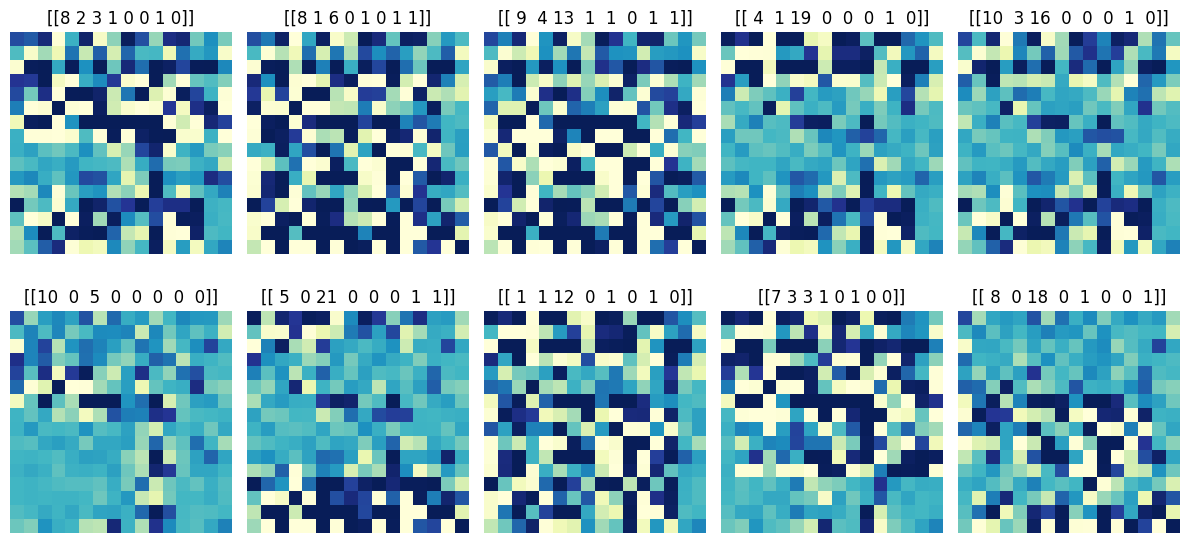

1/1 [==============================] - 0s 29ms/step
Epoch: 2/10, Batch: 401/1095, d loss=0.000, d acc=1.000, d mae=0.000, g loss=19.076, g mae1.000
1/1 [==============================] - 0s 29ms/step


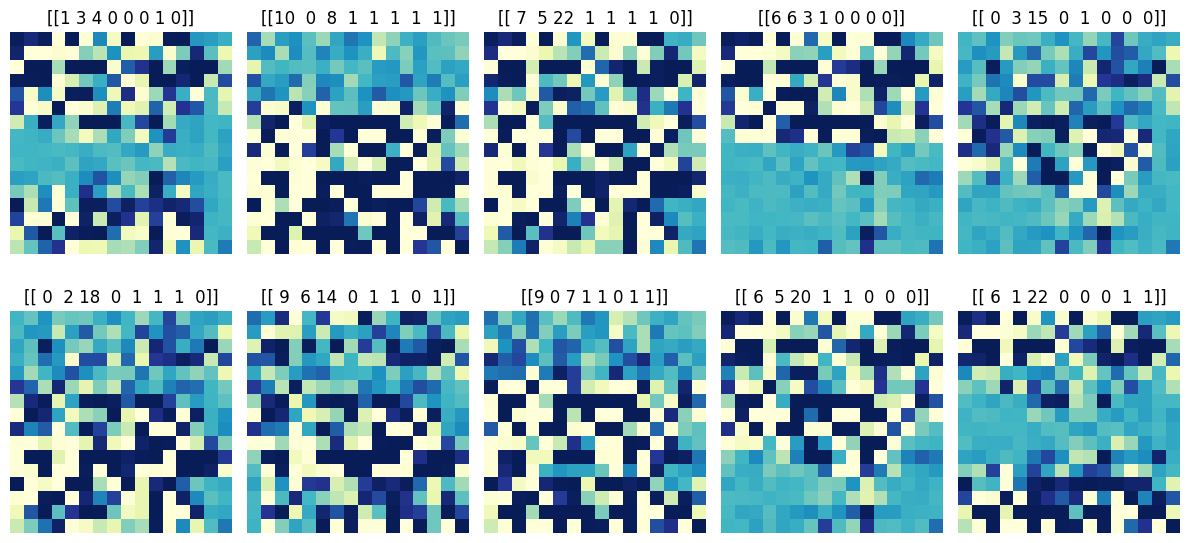

1/1 [==============================] - 0s 30ms/step
Epoch: 2/10, Batch: 601/1095, d loss=0.000, d acc=1.000, d mae=0.000, g loss=21.580, g mae1.000
1/1 [==============================] - 0s 34ms/step


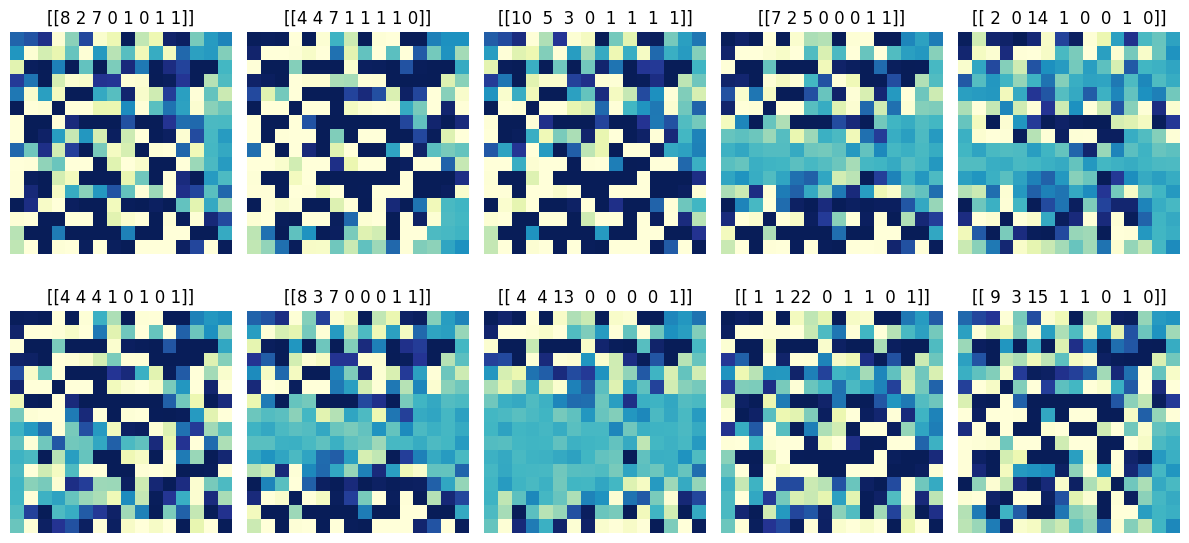

1/1 [==============================] - 0s 35ms/step
Epoch: 2/10, Batch: 801/1095, d loss=0.000, d acc=1.000, d mae=0.000, g loss=14.982, g mae1.000
1/1 [==============================] - 0s 33ms/step


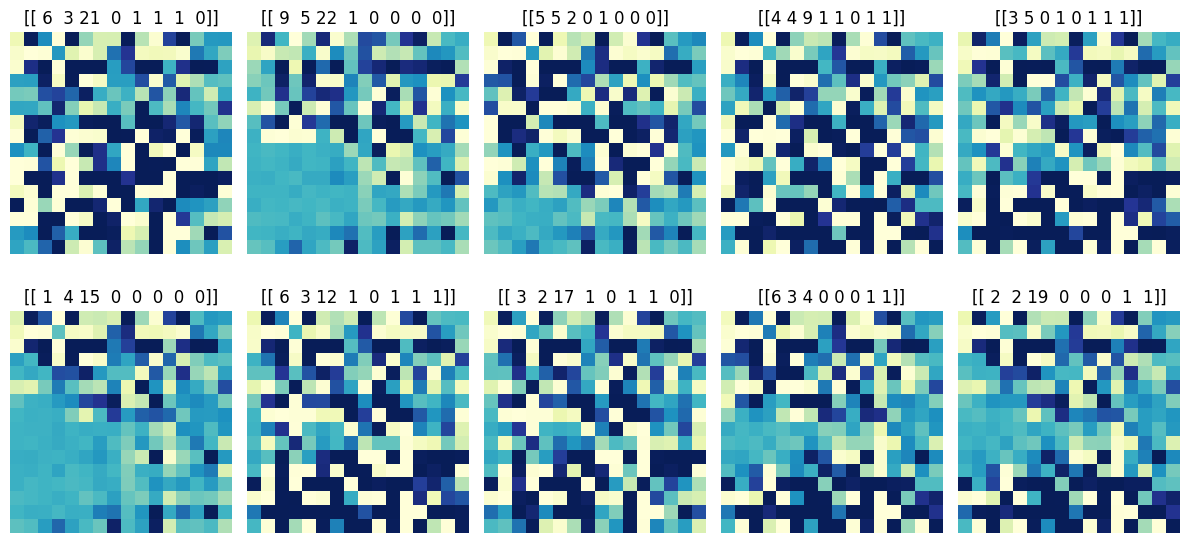

1/1 [==============================] - 0s 35ms/step
Epoch: 2/10, Batch: 1001/1095, d loss=0.000, d acc=1.000, d mae=0.000, g loss=14.327, g mae1.000
1/1 [==============================] - 0s 36ms/step


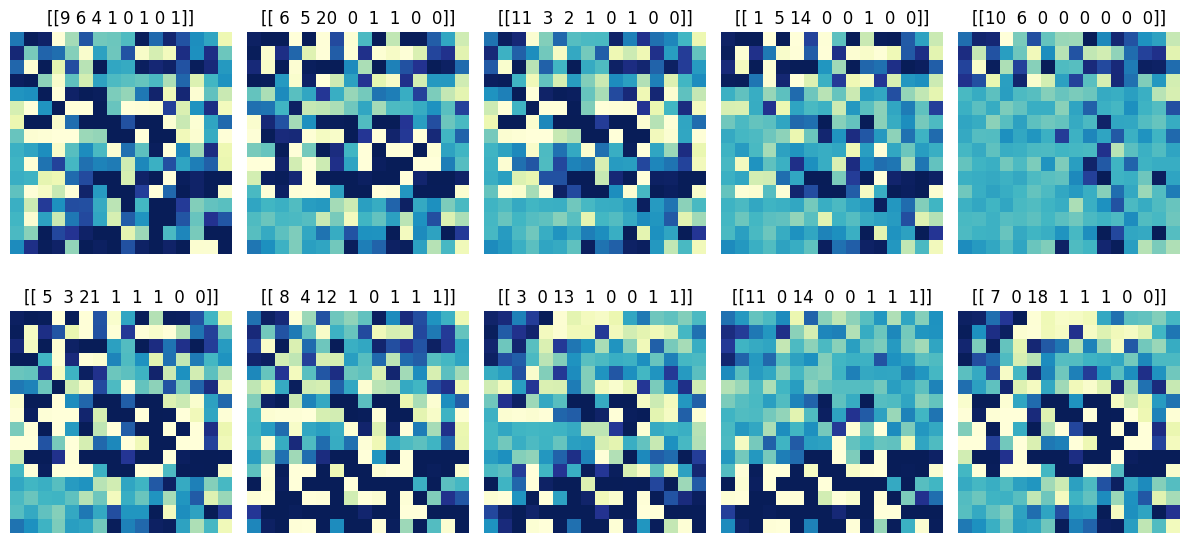

1/1 [==============================] - 0s 40ms/step
Epoch: 3/10, Batch: 1/1095, d loss=0.000, d acc=1.000, d mae=0.000, g loss=18.523, g mae1.000
1/1 [==============================] - 0s 38ms/step


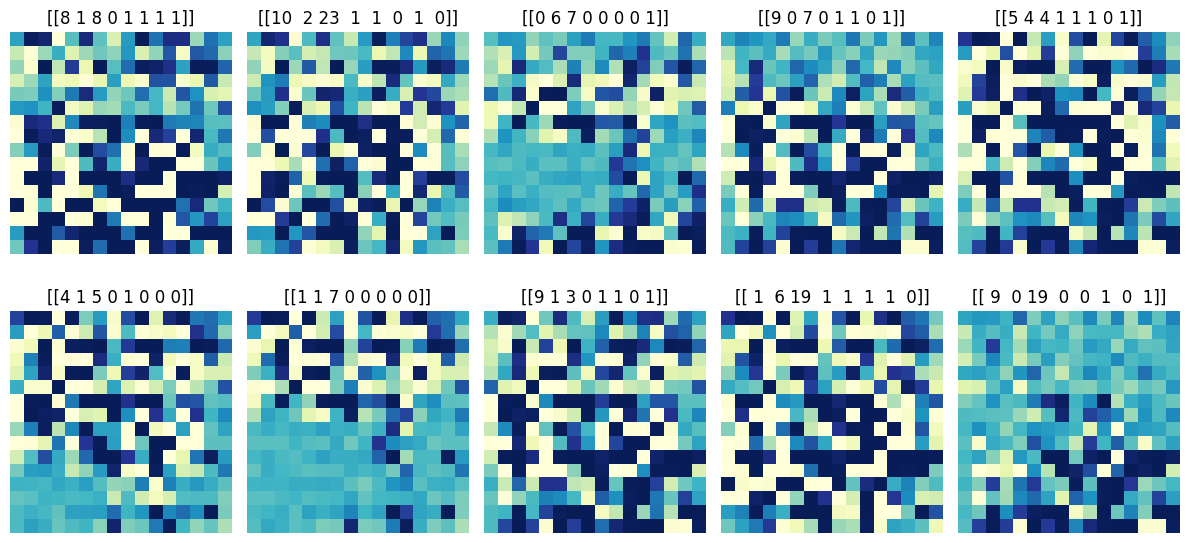

1/1 [==============================] - 0s 44ms/step
Epoch: 3/10, Batch: 201/1095, d loss=0.000, d acc=1.000, d mae=0.000, g loss=19.876, g mae1.000
1/1 [==============================] - 0s 44ms/step


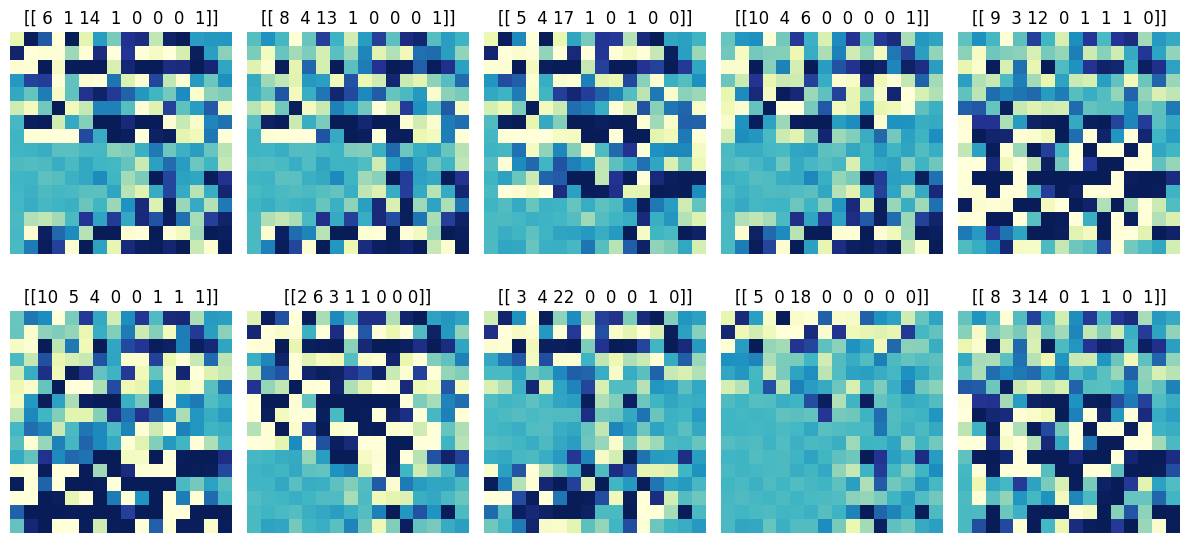

1/1 [==============================] - 0s 73ms/step
Epoch: 3/10, Batch: 401/1095, d loss=0.001, d acc=1.000, d mae=0.001, g loss=24.508, g mae1.000
1/1 [==============================] - 0s 70ms/step


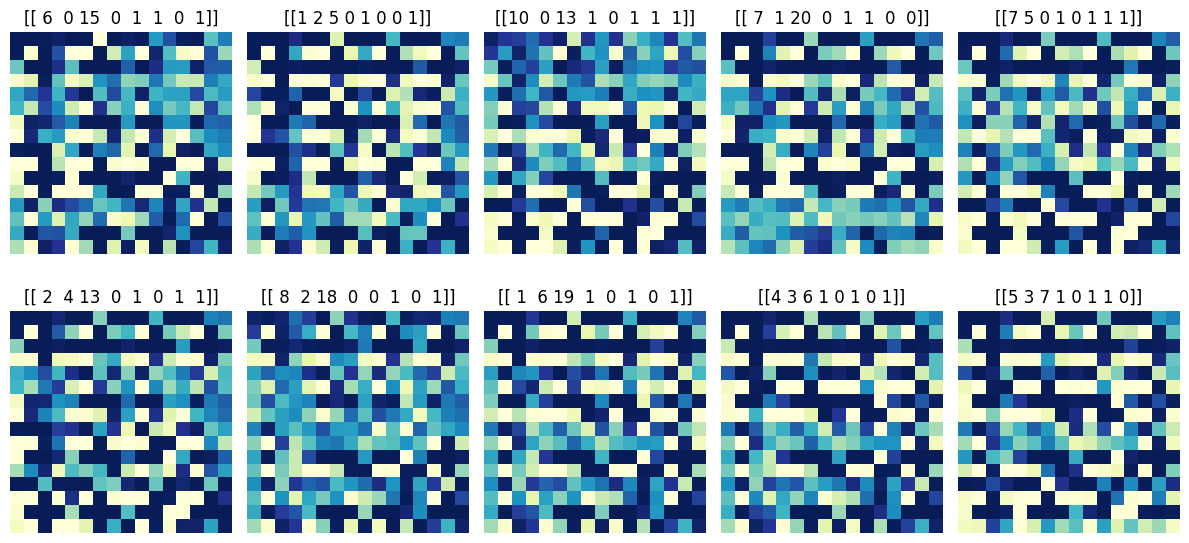

1/1 [==============================] - 0s 350ms/step
Epoch: 3/10, Batch: 601/1095, d loss=0.000, d acc=1.000, d mae=0.000, g loss=14.411, g mae0.995
1/1 [==============================] - 0s 379ms/step


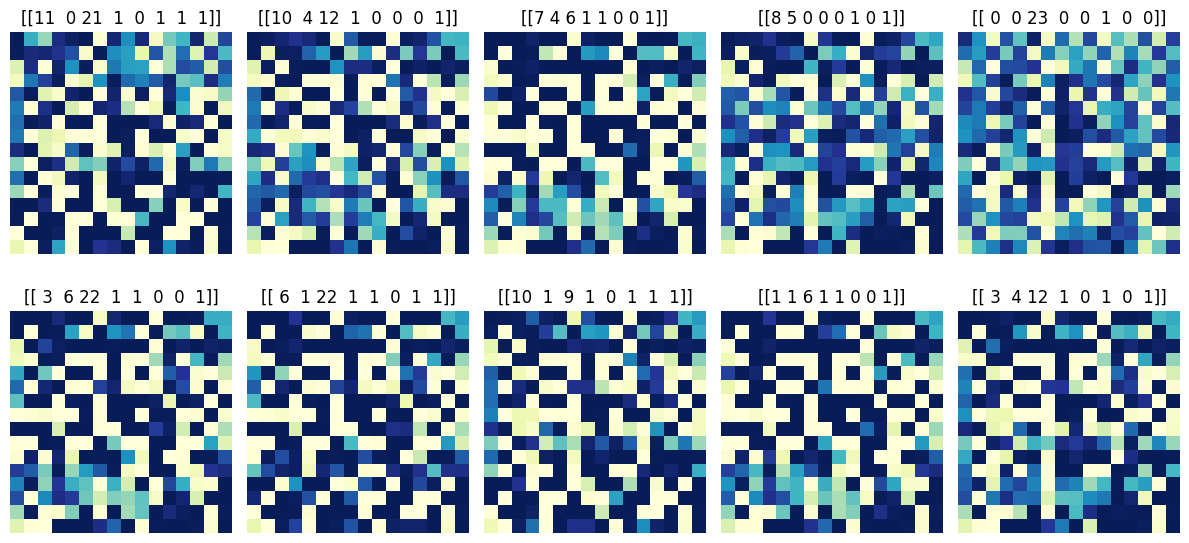

1/1 [==============================] - 0s 129ms/step
Epoch: 3/10, Batch: 801/1095, d loss=0.000, d acc=1.000, d mae=0.000, g loss=21.680, g mae1.000
1/1 [==============================] - 0s 239ms/step


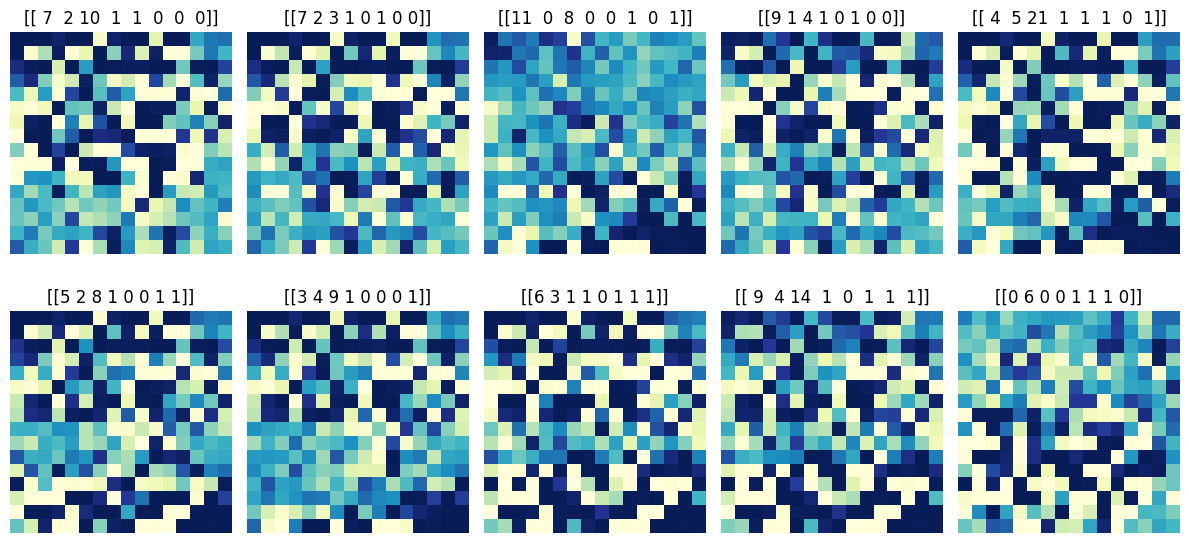

1/1 [==============================] - 0s 189ms/step


KeyboardInterrupt: 

In [59]:
mode = 'Taxi'
latent_dim = 50
discriminator = define_discriminator()
generator = define_generator(latent_dim)
gan = define_gan(generator, discriminator)
dataset = load_real_samples(mode)
EPOCHS = 10

gan_metrics = train(generator, discriminator, gan, mode, dataset, latent_dim, n_epochs=EPOCHS)


NameError: name 'gan_metrics' is not defined

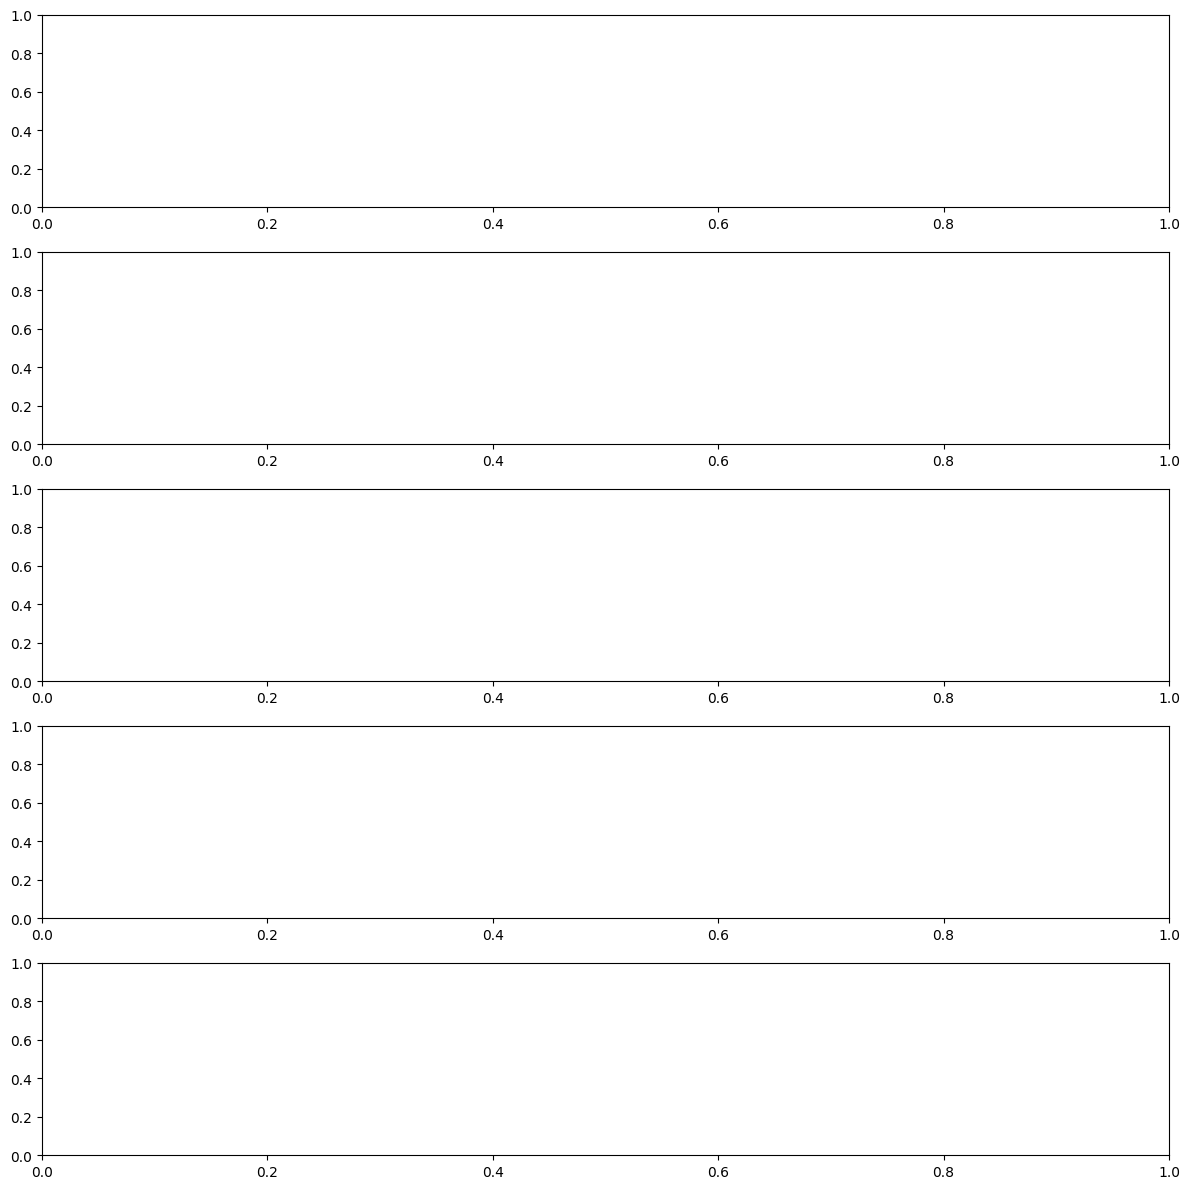

In [60]:
# Plot gan_metrics
fig, axs = plt.subplots(5, 1, sharey=False, tight_layout=True, figsize=(12,12), facecolor='white')
axs[0].plot(gan_metrics[:, 0], label='Discriminator Loss')
axs[0].set_title('Discriminator Loss')
axs[1].plot(gan_metrics[:, 1], label='Discriminator Accuracy')
axs[1].set_title('Discriminator Accuracy')
axs[2].plot(gan_metrics[:, 2], label='Discriminator MAE')
axs[2].set_title('Discriminator MAE')
axs[3].plot(gan_metrics[:, 3], label='Generator Loss')
axs[3].set_title('Generator Loss')
axs[4].plot(gan_metrics[:, 4], label='Generator MAE')
axs[4].set_title('Generator MAE')
plt.show()




# Predict

In [ ]:
model = tf.keras.models.load_model('Taxi_cgan_gen_1.h5')

In [62]:
label = weather[3]
label

array([[1., 4., 1., 0., 1., 0., 0., 0.]])

In [64]:
# latent_points, _ = generate_latent_points(50, 10)
latent_points, _ = generate_latent_points(50, 1)
# Get 10 random arrays from the weather data
# index = np.random.choice(weather.shape[0], 10, replace=False)
# labels = weather[index]
labels = weather[3].reshape(1, 1, 8)
# reshape labels to be [samples, 1]
# labels = labels.reshape(1, 1)
print(latent_points.shape, labels.shape)


X = model.predict([latent_points, labels])
# X = model.predict([latent_points, np.array([2])])

(1, 50) (1, 1, 8)
1/1 [==============================] - 0s 151ms/step


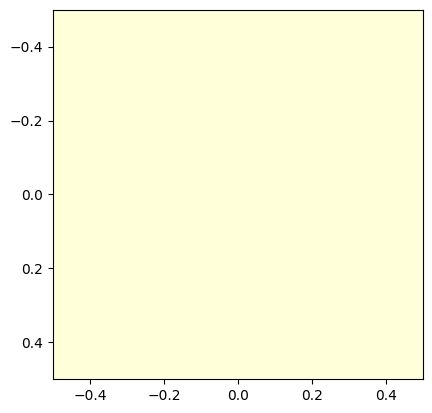

In [65]:
plt.imshow(X, cmap='YlGnBu')

1/1 [==============================] - 0s 53ms/step


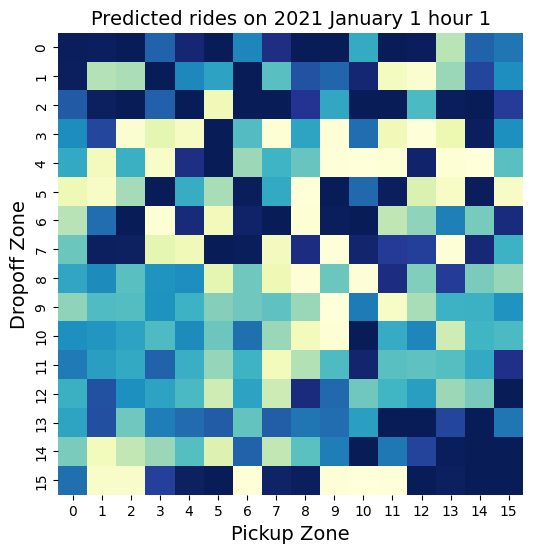

In [94]:
x_fake, y_fake = generate_fake_samples(generator, latent_dim, 10)

# Rescale from [-1, 1] to [0, 1]
X_tst = (x_fake[0] + 1) / 2.0
    
year = 2021
month = 1
day = 1
hour = 1

# x_fake[0][0][:,:,0]
plt.figure(figsize=(6,6))  
# plot one generated image from x_fake using seaborn heatmap

ax = sns.heatmap(x_fake[0][0][:,:,0], cmap="YlGnBu", cbar=False)
plt.title('Predicted rides on ' + str(year) + ' January ' + str(day) + ' hour ' + str(hour), fontsize=14)
plt.xlabel('Pickup Zone', fontsize=14)
plt.ylabel('Dropoff Zone', fontsize=14)
plt.show()

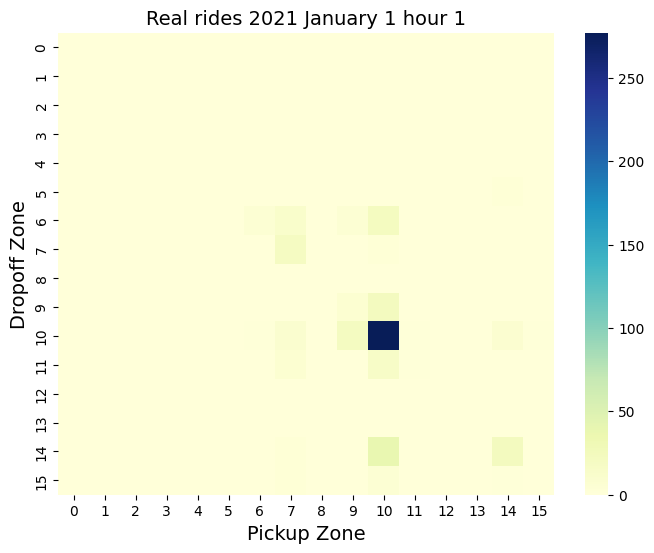

In [96]:
# Plot the demand in a heatmap for a given hour, day, and month of the x_test dataset
year = 2021
month = 1
day = 1
hour = 1

plt.figure(figsize=(8,6))
ax = sns.heatmap(taxi[((month)*(day)*(hour)),:,:,0], cmap="YlGnBu")
plt.title('Real rides ' + str(year) + ' January ' + str(day) + ' hour ' + str(hour), fontsize=14)
plt.xlabel('Pickup Zone', fontsize=14)
plt.ylabel('Dropoff Zone', fontsize=14)
plt.show()